In [14]:
import os
import tarfile
import urllib
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# Fetch the housing dataset
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
# Load the dataset as a panda DataFrame object
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Call the fetch function, and load the data into the 'housing' variable
fetch_housing_data()
housing = load_housing_data()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


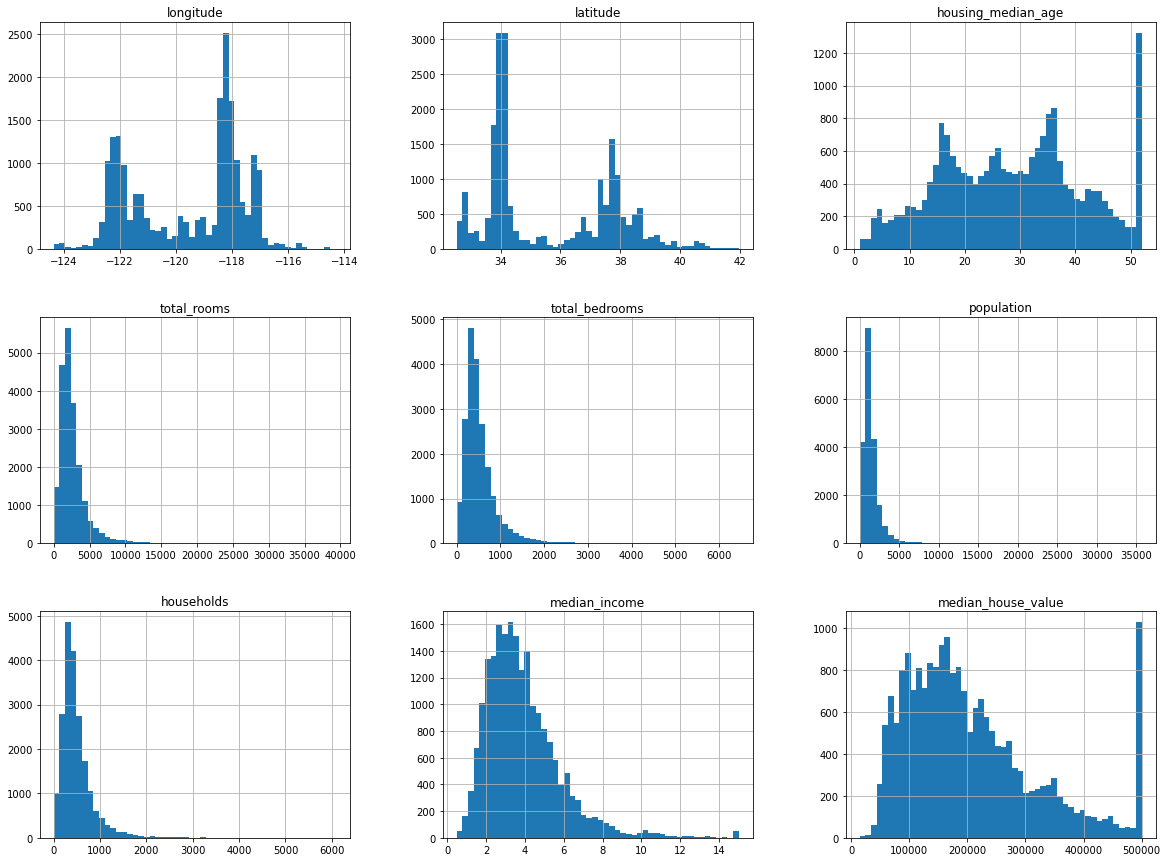

In [15]:
# View the first five lines of the DataFrame object
housing.head()

# View the description of the data
housing.info()

# View the different categories of the 'ocean_proximity' field of the dataset 
# and how many districts belong each category
housing["ocean_proximity"].value_counts()

# View a summary of the numerical attributes
housing.describe()

# Plot histograms for all the numerical attributes
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [16]:
# Function definition to randomly split instances of the dataset into a training set and test set, based on a test ratio.
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

# Split the data into a training set (80% of the data) and test set (20% of the data) 
# (80-20 is often the standard ratio, unless in the case of very large datasets)
train_set, test_set = split_train_test(housing, 0.2)

# Another random training/test set random divition using Scikit-Learn, in this case locking the random seed to 42
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

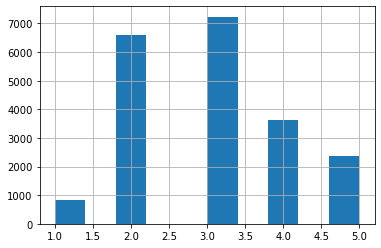

In [17]:
# Assuming the median income is a very important attribute to predict median housing prices, 
# we want to do stratified sampling based on income categories.

# We divide the median income into 5 categories (from the histograms) (0-1.5, 1.5-3, ... 6-inf)
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

# Stratified sampling with Scikit-Learn
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

# Drop the income category created
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

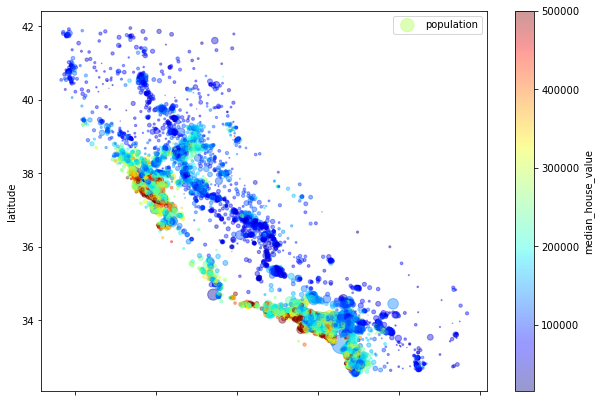

In [18]:
# Reset the housing data as the training data only and plot it. Circle radius describe district population 
# and the color represents the price.
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=housing["population"]/100, label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In [19]:
# Compute the standard correlation coefficient (from -1 to 1) between every pair of attributes
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

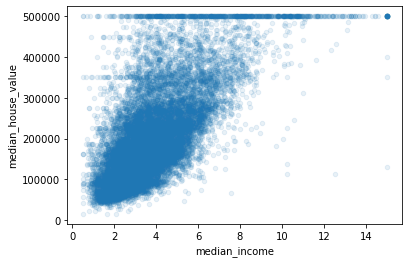

In [20]:
# As the median income has the most promising correlation accourding to the standard correlation coefficient, 
# I will take a closer look at this correlation
housing.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1)

# The lines in the plot indicate that it is probably smart to clean up the data before continuing
# to avoid the algorithm to learn to reproduce these quirks

In [21]:
# Defining some relations between attributesthat may be interesting that may not be too interesting by themselves
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

# Plot the new correlation matrix
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

# The new defined 'rooms_per_household' seems to have a promising correlation to the house value

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [22]:
# Clean data

# Restart with a clean dataset and seperate the labels and predictors
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Three options to deal with the missing values of the 'total_bedrooms' attribute for some of the districts
housing.dropna(subset=["total_bedrooms"]) # option 1 : Drop all districts that are missing the 'total_bedrooms' attribute
housing.drop("total_bedrooms", axis=1) # option 2 : Drop the entire 'total_bedrooms' attribute for all districts
median = housing["total_bedrooms"].median() # option 3 : Fill in the missing values for the 'total_bedrooms' attribute with the median value
housing["total_bedrooms"].fillna(median, inplace=True)


# Use the imputer from Scikit-Learn to fill in the missing values with the median value (option 3)
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
# Can only be done on a numeric set, so I am dropping the 'ocean_proximity' attribute for this calculation
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

imputer.statistics_
housing_num.median().values

# Replace missing values with the learned medians, and revert the data back into a panda DataFrame
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
index=housing_num.index)

In [25]:
# Get the housing attribute of the dataset (the only non-numerical attribute)
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

# Converting the 'ocean_proximity' categories to numbers
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

# OneHot encoded 'ocean_proximity' categories with Scikit_Learn
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [27]:
# Class with BaseEstimator and TransformerMixin from Scikit-Learn to facilitate the process of combining attributes on datasets 
# (like I did manually earlier)
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
            bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [30]:
# Using Pipeline and StandardScaler from Scikit-Learn to create a pipeline to impute missing values by the median, 
# combine attributes and perform standarization scaling on the numerical attributes on the training set
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [31]:
# Using ColumnTransformer from Scikit-Learn to implement and transform the full dataset in the full pipeline 
# (both numerical and non-numerical attributes)
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
    ])

# The prepared dataset; transformed, imputed, scaled and fit, ready for analysis
housing_prepared = full_pipeline.fit_transform(housing)

In [32]:
# Training a linear regression model on the data
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# Some tests and prints of the predictions
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [33]:
# Calculating the RMSE (Error) of the linear regression test above on the training data
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

# This model underfits the data

68628.19819848923

In [41]:
# Training a DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

# Evaluation of the training set gives 0.0 as error, indicating that we are probably dealing with a gross overfitting
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

# Evaluating the DecisionTreeRegression model using k-fold cross validation with 10 folds (better evaluation)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
    scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

# Reevaluate the linear regression with the k-fold cross validation
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
    scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

# Indicates that the DecisionTreeRegressor overfits so badly that the linear regression performs better

Scores: [68343.4653007  66788.02885146 69768.68703457 68863.26341476
 70084.08889132 75549.93747913 71251.99584129 71182.26153956
 76279.22871379 69327.35223081]
Mean: 70743.83092973958
Standard deviation: 2872.7857257517935
Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798348


In [45]:
# Training a RandomForestRegressor and evaluate it with the first evaluation method
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18861.56594060736

In [46]:
# Evaluation with the k-fold cross evaluation
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
    scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

# The low score on the training data in comparison to the cross validation indicates that we are still dealing with overfitting

Scores: [49455.5671269  47542.78589373 50241.57671626 52246.77873761
 49495.63460553 53626.45410358 48726.38850495 48114.82642427
 53081.27835544 50469.70678802]
Mean: 50300.099725628395
Standard deviation: 1970.697950160074


In [59]:
# Use GridSearchCV from Scikit-Learn to search for the optimal combination of hyperparameters for the RandomForestRegressor
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
    scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

# The best parameters found after the GridSearchCV
grid_search.best_params_

# The best parameters being the highest possible values indicates that it would be interesting to explore more 
# (and higher) values. This could be done more efficiently with the RandomizedSearchCV instead of the GridSearchCV

{'max_features': 8, 'n_estimators': 30}

In [60]:
# Get the best estimator directly from the GridSearchCV
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [61]:
# Print the evaluation scores of the tests run by the GridSearchCV
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64367.54509951677 {'max_features': 2, 'n_estimators': 3}
55661.956708467915 {'max_features': 2, 'n_estimators': 10}
52943.25439756167 {'max_features': 2, 'n_estimators': 30}
61163.078622323475 {'max_features': 4, 'n_estimators': 3}
53031.21315930351 {'max_features': 4, 'n_estimators': 10}
50565.05811994232 {'max_features': 4, 'n_estimators': 30}
59003.16381920702 {'max_features': 6, 'n_estimators': 3}
52564.27223086364 {'max_features': 6, 'n_estimators': 10}
50106.15495432103 {'max_features': 6, 'n_estimators': 30}
58753.6962279041 {'max_features': 8, 'n_estimators': 3}
51972.38214339977 {'max_features': 8, 'n_estimators': 10}
49976.01891163013 {'max_features': 8, 'n_estimators': 30}
62604.03805034555 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54502.36050585061 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60412.05197947124 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52376.26488516018 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

In [62]:
# Feature importance
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

# Apparently only one 'ocean_proximity' category is really useful, so it may be interesting to drop the others

[(0.3597371472024178, 'median_income'),
 (0.137106992686934, 'INLAND'),
 (0.11298370444240079, 'pop_per_hhold'),
 (0.0735670462141927, 'longitude'),
 (0.06912510482263703, 'latitude'),
 (0.0673350144647643, 'bedrooms_per_room'),
 (0.05727680563716091, 'rooms_per_hhold'),
 (0.042510694213843084, 'housing_median_age'),
 (0.01551699847570779, 'population'),
 (0.014915662893259947, 'total_rooms'),
 (0.014580053529372338, 'total_bedrooms'),
 (0.013951741318099075, 'households'),
 (0.010369384669674186, '<1H OCEAN'),
 (0.006923924749510545, 'NEAR OCEAN'),
 (0.004034310950841351, 'NEAR BAY'),
 (6.541372918427777e-05, 'ISLAND')]

In [65]:
# Evaluate the fine tuned model on the test set using the best estimator found with the GridSearchCV method
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47680.775635228034

In [66]:
# Compute a 95% confidence interval for the generalization error
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
    loc=squared_errors.mean(),
    scale=stats.sem(squared_errors)))

array([45664.4654165 , 49615.21267292])

In [ ]:
# To improve and continue studying this dataset and its techniques, check out additional exercises in the book 
# "Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow" at the end of chapter 2